In [1]:
import time
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_thetas_grid(min_theta, max_theta):
    theta1 = np.linspace(min_theta, max_theta, 200)
    theta2 = np.linspace(min_theta, max_theta, 200)
    thetas_unflat = np.meshgrid(theta1, theta2)
    return np.vstack((thetas_unflat[0].flatten(), thetas_unflat[1].flatten())).T.astype(np.float32)

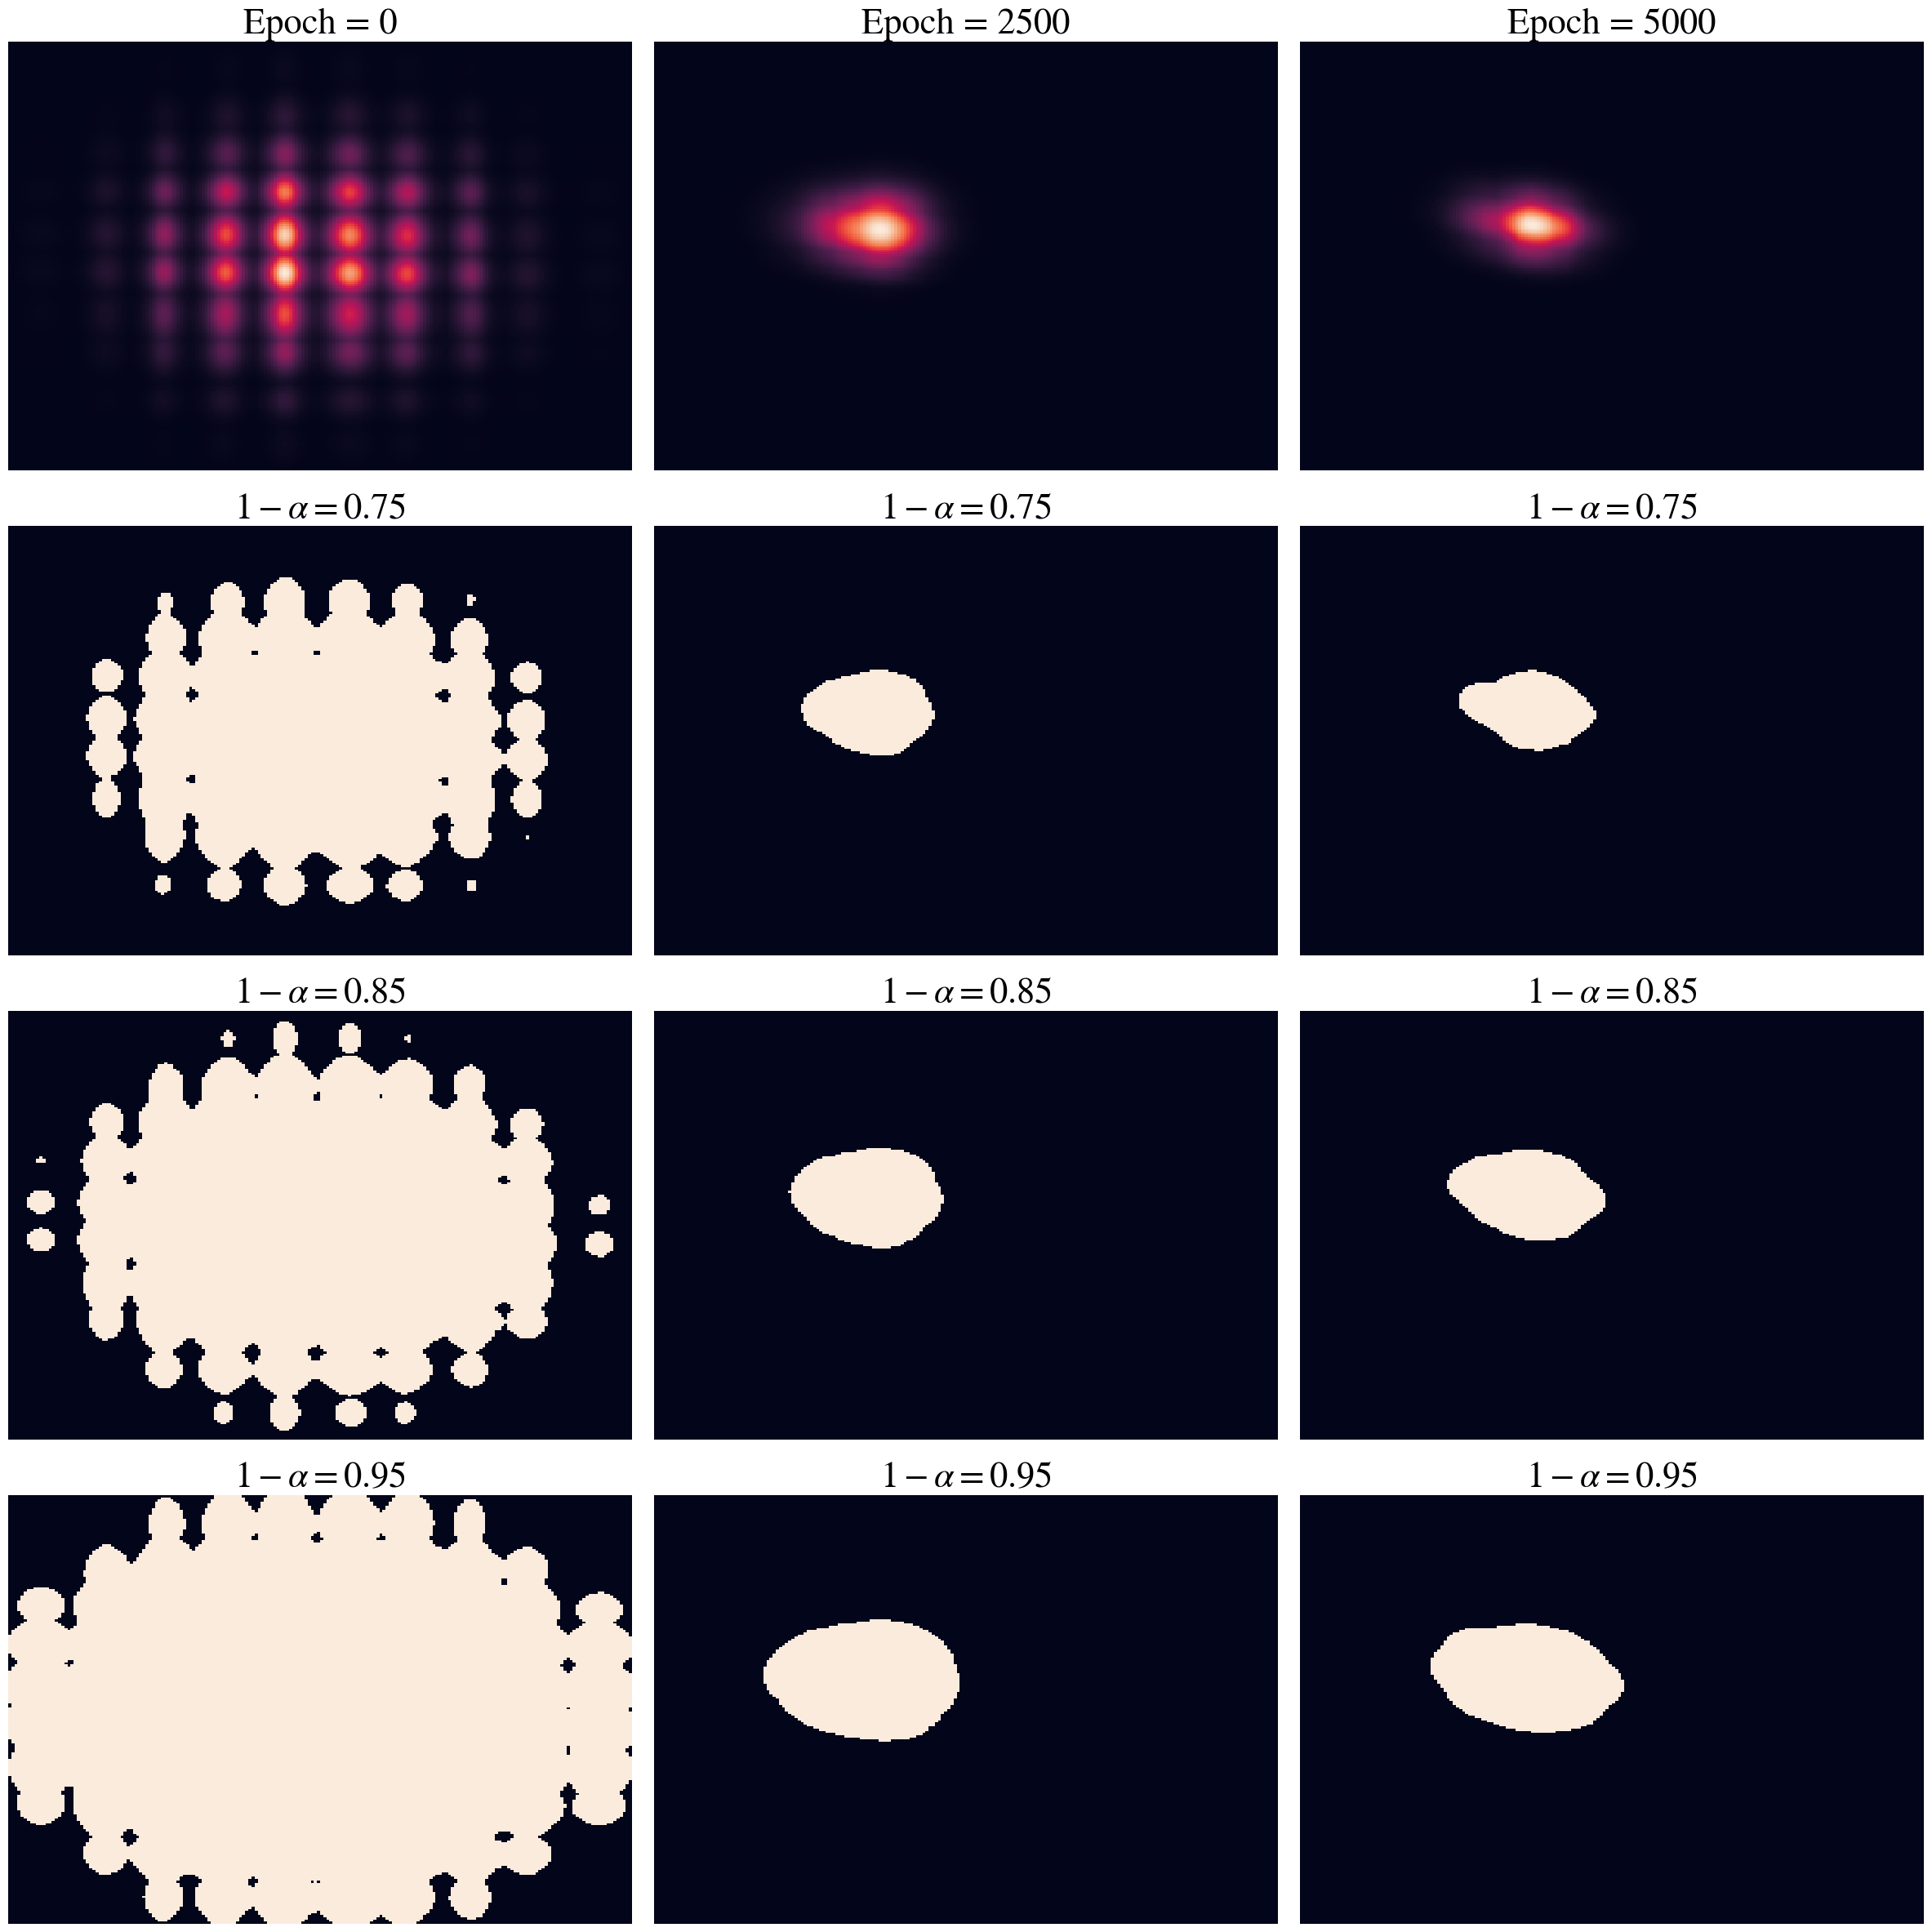

In [14]:
task_names = [
    'two_moons',
    'slcp',
    'gaussian_mixture',
    'gaussian_linear',
]
task_name = "bernoulli_glm_raw"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

sims = 10_000 # same number for both test and calibration
calibration_theta = prior.sample((sims,))
calibration_x = simulator(calibration_theta)
calibration_theta = calibration_theta[...,:2]

thetas = get_thetas_grid(-3, 3)
test_sim = 1
test_theta = prior.sample((test_sim,))
test_x = simulator(test_theta)
test_theta = test_theta[...,:2]
test_x_tiled = np.tile(test_x, (thetas.shape[0], 1)).astype(np.float32)

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24,24))

for j, epoch in enumerate([0, 2500, 5000]):
    device = "cpu"
    fn = f"{task_name}"
    cached_fn = f"{task_name}_marg_epoch={epoch}.nf"
    with open(cached_fn, "rb") as f:
        encoder = pickle.load(f)
    encoder.to(device)

    cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
    desired_coverages = [0.75, 0.85, 0.95]
    
    probs = encoder.log_prob(thetas, test_x_tiled).detach().cpu().exp().numpy()
    probs_map = probs.reshape((200, 200))
    
    axs[0, j].set_title("Epoch = " + str(epoch), fontsize=32)
    axs[0, j].tick_params(left=False, bottom=False)
    axs[0, j].set(xticklabels=[], yticklabels=[])
    sns.heatmap(probs_map, ax=axs[0, j], cbar=False, xticklabels=False, yticklabels=False)
    
    for i, desired_coverage in enumerate(desired_coverages):
        ax = axs[i + 1, j]
        ax.set_title(r"$1-\alpha = " + str(desired_coverage) + "$", fontsize=32)
        conformal_quantile = np.quantile(cal_scores, q = desired_coverage)
        sns.heatmap((1 / probs_map) < conformal_quantile, ax=ax, cbar=False, xticklabels=False, yticklabels=False)

plt.tight_layout()
plt.savefig(f"sbi_sets_{task_name}.png")